In [1]:
import pandas as pd
import numpy as np

Punkte in 3d Erstellen

In [2]:
import pandas as pd

size = 1000
n_dim = 3

df = pd.DataFrame(2 * (np.random.rand(size, n_dim) - .5))
df.columns = ["x", "y", "z"]

def comp(row):
    if abs(row["x"]) + abs(row["y"]) + abs(row["z"]) >= 1:
        return 1
    else: 
        return 0

df['group'] = df.apply(lambda row: comp(row), axis = 1)

#print(df)

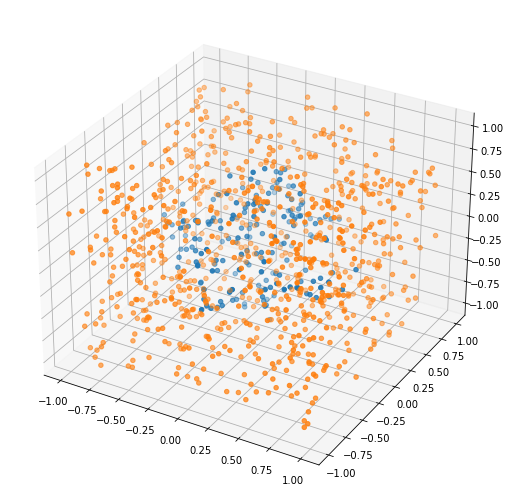

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (12,9))
ax = fig.add_subplot(111, projection='3d')

for grp_name, grp_idx in df.groupby('group').groups.items():
    x = df.iloc[grp_idx,0]
    y = df.iloc[grp_idx,1]
    z = df.iloc[grp_idx,2]
    ax.scatter(x,y,z, label=grp_name)  # this way you can control color/marker/size of each group freely
    #ax.scatter(*df.iloc[grp_idx, [0, 1, 2]].T.values, label=grp_name)  # if you want to do everything in one line, lol

plt.show()

Planes erstellen

In [4]:
planes = [[[0,0,0],[1,0,0]],
          [[0,0,0],[0,1,0]],
          [[0,0,0],[0,0,1]],
          [[5,5,5],[1,1,1]]]

[[0, 0, 0], [1, 0, 0]]
[[0, 0, 0], [0, 1, 0]]
[[0, 0, 0], [0, 0, 1]]
[[5, 5, 5], [1, 1, 1]]


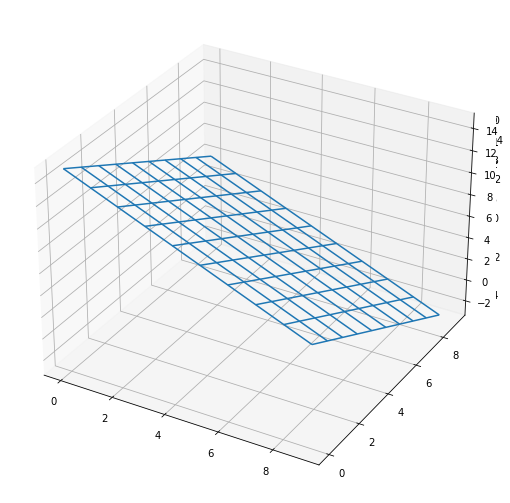

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#fig = plt.figure(figsize=(12, 9)).gca(projection='3d')

fig = plt.figure(figsize = (12,9))
ax = fig.add_subplot(projection='3d')
    
for each in planes:
    print(each)
    point  = np.array(each[0])
    normal = np.array(each[1])
    ax = fig.add_subplot(projection='3d')
    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate
    # d and we're set
    d = -point.dot(normal)
    # create x,y
    xx,yy = np.meshgrid(range(10), range(10))
    # calculate corresponding z
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. / (normal[2]+0.00000001)
    # plot the surface
    ax.plot_wireframe(xx, yy, z)

plt.show()

Trying to build a Convex Hull

In [6]:
# for n dimension we need n + 1 Hyperplanes to build a convex Hull encompassing points

# planes = []

# for i in range n_dim + 1:
    

Calculating Loss

for calculating 2 orhtogonal vectors for a given vector https://stackoverflow.com/questions/33658620/generating-two-orthogonal-vectors-that-are-orthogonal-to-a-particular-direction

for determining if Point is to the right of a plane defined by a nromal vecotr https://qr.ae/pvgYcL

In [9]:
# # find 2 orthogonal vectors
# plane = np.array(plane)
# # find first orthogonal vector:
# x = np.random.randn(3)          # take a random vector
# x -= x.dot(plane) * plane       # make it orthogonal to k
# x /= np.linalg.norm(x)          # normalize it
# # find second orthogonal vector
# y = np.cross(plane, x)          # cross product with k
# print(x,y)

In [129]:
#calculate if P is in the half space that v points into from point A on the plane that divides the space
a = np.array([0,0,0])
plane = np.array([0,0,0])
point = np.array([-1,0,0])
np.dot(plane, (point - a))

0

# Tensorflow Model

In [45]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K

import numpy as np

In [ ]:
train = df.sample(frac=0.8,random_state=200)
test  = df.drop(train.index)

train_df = pd.DataFrame({
            "point": train[["x","y","z"]].values.tolist(),
            "label": train[["group"]].values.tolist()
        })

train_points = np.array([np.array(x) for x in train_df["point"].values.tolist()])
train_labels = np.array(train_df["label"].values.tolist())

train_ds = [train_points, train_labels]

test_df = pd.DataFrame({
            "point": test[["x","y","z"]].values.tolist(),
            "label": test[["group"]].values.tolist()
        })

test_points = np.array([np.array(x) for x in test_df["point"].values.tolist()])
test_labels = np.array(test_df["label"].values.tolist())

test_ds = [test_points, test_labels]

In [97]:
class InHull(tf.keras.layers.Layer):
    def __init__(self, units=1): # one output
        super().__init__()
        self.units = units
    
    def build(self, input_shape):
        w_init=tf.random_normal_initializer()
        self.w = tf.Variable(initial_value = w_init(shape = (2,input_shape[-1]),
                                                    dtype="float32"), 
                             trainable = True)
        print("Weights in layer: ", self.w)
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(initial_value = b_init(shape = (self.units,),dtype = "float32"), trainable = True)

    def call(self, inputs):
        return K.sum(self.w[0] * (self.w[1] - inputs), axis = -1, keepdims = True)
        # return K.batch_dot(inputs * self.w, axis =-1,keepdims = True) + self.b


In [107]:
x = tf.constant([6,5,5], dtype = "float32")
plane = tf.constant([[5, 5, 5], [1, 1, 1]], dtype = "float32")
print(x, plane)
# C = K.sum(x * plane[0], axis = 0)#, keepdims = True)

trueResult = np.dot(plane[1], (plane[0] - x))
C = K.sum(plane[1] * (plane[0] - x), axis = 0, keepdims = True)
print(trueResult, C)

linear_layer = InHull(1)
y = linear_layer(x)
print("The Layer predicted: ", y)

tf.Tensor([6. 5. 5.], shape=(3,), dtype=float32) tf.Tensor(
[[5. 5. 5.]
 [1. 1. 1.]], shape=(2, 3), dtype=float32)
-1.0 tf.Tensor([-1.], shape=(1,), dtype=float32)
Weights in layer:  <tf.Variable 'in_hull_23/Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 0.04053844,  0.01903584,  0.01429728],
       [ 0.00113348, -0.02244631,  0.0245842 ]], dtype=float32)>
The Layer predicted:  tf.Tensor([-0.4099261], shape=(1,), dtype=float32)


In [146]:
from tensorflow import keras


def in_convex_hull(point, plane_point, plane_normal):
    if np.dot(plane, (point - a)) == 1:
        return true
    return false

def custom_loss(actual, pred):
    loss = 0
    return loss
def custom_layer():
    return

model = keras.Sequential([keras.layers.Dense(units=1, input_shape=[3])])
model.add(keras.layers.Dense(1000))
model.add(keras.layers.Dense(24))
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics = ["accuracy"])

xs = np.array([[1.0, 1.0, 1.0]])
ys = np.array([1])

history = model.fit(xs, ys, epochs=10, batch_size=1, verbose = 1)

Epoch 1/10
1/1 [==============================] - 0s 380ms/step - loss: 9.8956 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 3ms/step - loss: 9.0457 - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 8.7112 - accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 8.5685 - accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 8.4656 - accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 8.0133 - accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 3ms/step - loss: 7.7975 - accuracy: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 7.7170 - accuracy: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 7.6552 - accuracy: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 7.6037 - accuracy: 0.0000e+

In [130]:
from tensorflow import keras


def in_convex_hull(point, plane_point, plane_normal):
    if np.dot(plane, (point - a)) == 1:
        return true
    return false

def custom_loss(actual, pred):
    loss = 0
    return loss
def custom_layer():
    return

model = keras.Sequential([keras.layers.Dense(units=1, input_shape=[800,3])])
model.add(keras.layers.Dense(1000))
model.add(keras.layers.Dense(24))
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics = ["accuracy"])

xs = train_points
xs = np.array([np.random.rand(800,3) for i in range(1)])

ys = np.array([train_labels])

history = model.fit(xs, ys, epochs=10, batch_size=1, verbose = 1)


Epoch 1/10
1/1 [==============================] - 0s 391ms/step - loss: 8.5176 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 7.5313 - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 7.2507 - accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 7.0150 - accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 6.7952 - accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 6.5391 - accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 6.3024 - accuracy: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 6.0377 - accuracy: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 5.7690 - accuracy: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 6ms/step - loss: 5.5112 - accuracy: 0.0000e+

In [95]:
history.history

{'loss': [1.5344727039337158,
  0.5439260601997375,
  0.505598247051239,
  0.4892033636569977,
  0.49211326241493225,
  0.4920598566532135,
  0.4919050335884094,
  0.4918493926525116,
  0.49421292543411255,
  0.4926723539829254]}

# Test

In [11]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

#for n dimensions we have 
# Points defined by n numbers
# n + 1 Planes that cut the space R defined by each
#   # 1 normal vector
#   # 1 Point on the plane
# normal vector and point are to be optimized such that
# most number of points are within convex hull that is surrounding them

2022-12-07 12:56:35.954072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 12:56:36.053124: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-07 12:56:36.053137: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-07 12:56:36.597270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

TensorFlow version: 2.11.0


In [13]:
# Create a `Sequential` model and add a Dense layer as the first layer.
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(3,)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
# Now the model will take as input arrays of shape (None, 3)
# and output arrays of shape (None, 32).
# Note that after the first layer, you don't need to specify
# the size of the input anymore:
model.add(tf.keras.layers.Dense(8))
model.output_shape
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 392
Trainable params: 392
Non-trainable params: 0
_________________________________________________________________


2022-12-07 12:56:37.470587: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-07 12:56:37.470600: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-07 12:56:37.470630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thilo-HP-ProDesk-600-G6-Microtower-PC): /proc/driver/nvidia/version does not exist
2022-12-07 12:56:37.470783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Choose an optimizer and loss function for training: 
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [15]:
# Use tf.GradientTape to train the model:
@tf.function
def train_step(points, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(points, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
# Test the model:
@tf.function
def test_step(points, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(points, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)


In [30]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(np.array(images), labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )


ValueError: in user code:

    File "/tmp/ipykernel_278695/1084042546.py", line 7, in train_step  *
        predictions = model(points, training=True)
    File "/home/thilo/miniconda3/envs/convexgating/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/thilo/miniconda3/envs/convexgating/lib/python3.8/site-packages/keras/engine/input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (3,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(3,), dtype=float64)
      • training=True
      • mask=None
